### Optional Research Challenge

Given: are two image stacks, each stored in a .tif file, and each having 300 layers (individual images)

You can view these stacks, for example, in ImageJ (drag&drop): https://imagej.net/ij/ , or simply implement a python script that loads and display them (you can use ChatGPT & co.
to generate one).

Both images stacks encode focus / defocus of a scenery (plants). Focus changes from top (first layer in the stacks) to bottom (last layers in the stacks). See example layers in the following slides. 

It appears, that out-of-focus regions always have a similar noise pattern (i.e. the standard deviation in such regions is similar) while in-focus regions have very different noise patterns (either extremely high at edge boundaries, or extreme low at surfaces) with corresponding standard deviations.

**Task**: Can you distinguish (segment) between out-of-focus (with common noise pattern for out-of-focus regions) and in-focus (with noise patterns that are very different from the
out-of-focus patterns) regions?

**Hint**: Models, such as computing and comparing std. deviation, lead to noisy results. They are too simple to describe the noise statistics. Approach an ML-solution that learns how
to describe the noise statistics better (e.g., via more than one (learned) operations, such as kernels in multiple conv. layers – as std. deviation is only one modeled (not learned)
operation).

**Hint 2**: The noise statistics of out-of-focus and in-focus regions are “similar” within the same stack. They might be slightly different in other stacks.

**Submission**: Submit only (OK) working solutions (no solutions that don’t work at all or deliver bad results). You need to submit your code, the segmented results (images), and a
short description (you chose the format and length) on how you solved the problem. Any help (including LLMs) is allowed. Deadline: 10.12.2024, 12 noon, to oliver.bimber@jku.at
(3 weeks).

**General**: At max. you can gain 25% of your lab points (which is equivalent to one full assignment) in addition. These points can be used to compensate for missing assignment
points (to improve your grade), or to skip any upcoming assignments (and compensate for it with the points of the research challenge). Note, that points of the research challenge
are on top the points of the regular assignments. Thus, the research challenge is optional, and all students doing only the regular assignments have a change to achieve 100% of
their lab grade with them only. This research challenge is intended for motivated students that are underchallenged with the regular assignments and are interested in solving more
research oriented tasks. You can approach this research challenge alone or as team of two (each getting the same points).

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# Definizione di un autoencoder convoluzionale ridotto
class ReducedConvAutoencoder(nn.Module):
    def __init__(self):
        super(ReducedConvAutoencoder, self).__init__()
        # Encoder con meno livelli e meno feature maps
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        # Decoder con meno livelli e meno feature maps
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Sigmoid per ottenere valori tra 0 e 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Caricamento del dataset
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Converti in scala di grigi
        if self.transform:
            image = self.transform(image)
        return image

# Percorso alle immagini
image_paths = ["stacks/stack1.tif", "stacks/stack2.tif"]

# Trasformazioni
transform = transforms.Compose([transforms.ToTensor()])

# Dataset e DataLoader
dataset = ImageDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inizializzazione del modello, della loss e dell'optimizer
model = ReducedConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestramento dell'autoencoder
epochs = 30  # Riduciamo le epoche per evitare overfitting su un modello più semplice
for epoch in range(epochs):
    running_loss = 0.0
    for data in dataloader:
        # Passa le immagini attraverso il modello
        output = model(data)
        loss = criterion(output, data)  # MSE tra input e output
        # Ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Stampa la loss media per ogni epoca
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(dataloader)}")

# Salva il modello addestrato
torch.save(model.state_dict(), "autoencoder.pth")


Epoch [1/30], Loss: 0.29120326042175293
Epoch [2/30], Loss: 0.29008781909942627
Epoch [3/30], Loss: 0.2890295088291168
Epoch [4/30], Loss: 0.2879536747932434
Epoch [5/30], Loss: 0.2868264317512512
Epoch [6/30], Loss: 0.2855874001979828
Epoch [7/30], Loss: 0.2842530310153961
Epoch [8/30], Loss: 0.282787024974823
Epoch [9/30], Loss: 0.28104862570762634
Epoch [10/30], Loss: 0.2790353298187256
Epoch [11/30], Loss: 0.27663055062294006
Epoch [12/30], Loss: 0.27367544174194336
Epoch [13/30], Loss: 0.27016812562942505
Epoch [14/30], Loss: 0.2657773494720459
Epoch [15/30], Loss: 0.2603352665901184
Epoch [16/30], Loss: 0.2538001835346222
Epoch [17/30], Loss: 0.24579161405563354
Epoch [18/30], Loss: 0.23587888479232788
Epoch [19/30], Loss: 0.22398565709590912
Epoch [20/30], Loss: 0.21006350219249725
Epoch [21/30], Loss: 0.19460222125053406
Epoch [22/30], Loss: 0.17831192910671234
Epoch [23/30], Loss: 0.16209927201271057
Epoch [24/30], Loss: 0.1471634954214096
Epoch [25/30], Loss: 0.13423417508602

In [32]:
# Carica il modello addestrato
model = ReducedConvAutoencoder()
model.load_state_dict(torch.load("autoencoder.pth"))
model.eval()  # Imposta il modello in modalità di valutazione


/var/folders/hh/y2mymwpd0717xb2bwg9nql7c0000gn/T/ipykernel_4291/1772593278.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder.

ReducedConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

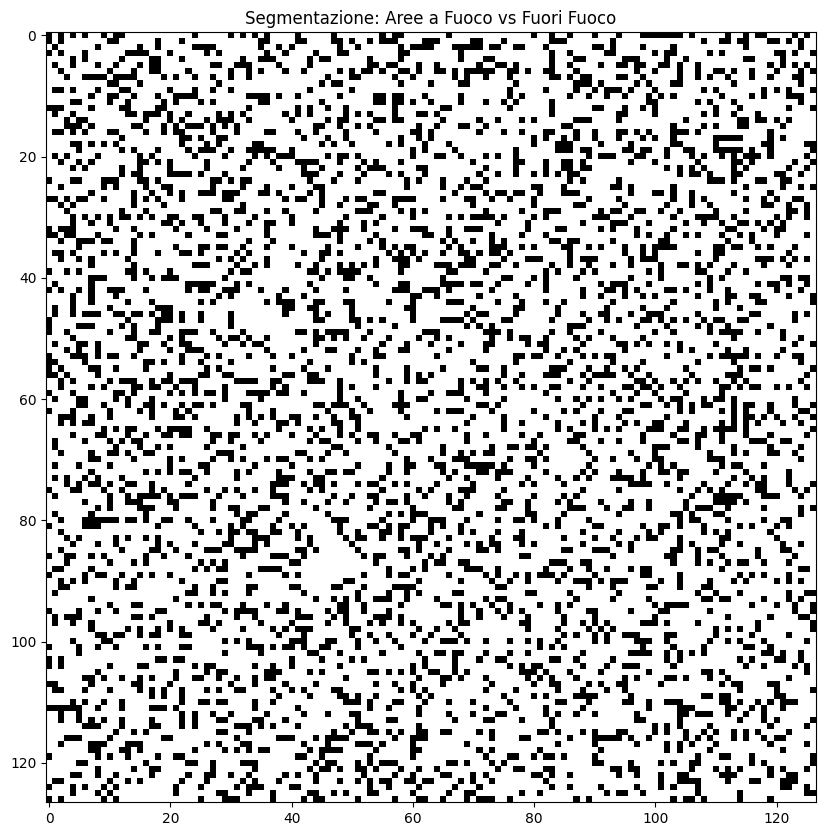

In [33]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

# Carica l'immagine
image_path = "stacks/stack1.tif"
image = Image.open(image_path).convert("L")  # Converti in scala di grigi

# Trasforma l'immagine in tensor e dividi in patch
transform = transforms.ToTensor()
image_tensor = transform(image)

# Modifica per estrarre patch di dimensioni moderate con sovrapposizione
patch_size = 16
overlap = 8  # Sovrapposizione del 50%
patches = []
h, w = image_tensor.shape[1], image_tensor.shape[2]
patch_h_count = (h - patch_size) // (patch_size - overlap) + 1
patch_w_count = (w - patch_size) // (patch_size - overlap) + 1

for i in range(0, h - patch_size + 1, patch_size - overlap):
    for j in range(0, w - patch_size + 1, patch_size - overlap):
        patch = image_tensor[:, i:i + patch_size, j:j + patch_size]
        if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
            patches.append(patch)

# Crea un batch di patch da analizzare
patches_tensor = torch.stack(patches)

# Simulazione degli errori di ricostruzione per ogni patch (assumendo che errors_array sia stato calcolato in precedenza)
# Nota: sostituire 'errors_array' con la lista di errori calcolati tramite l'autoencoder
errors_array = np.random.rand(len(patches))  # Questo è solo un esempio, usa i tuoi errori reali

# Imposta una soglia per distinguere le aree a fuoco e fuori fuoco
threshold = np.percentile(errors_array, 75)  # Ad esempio il 75° percentile come soglia

# Crea una mappa di segmentazione basata sull'errore
segmentation_map = []
for error in errors_array:
    if error > threshold:
        segmentation_map.append(0)  # Fuori fuoco
    else:
        segmentation_map.append(1)  # A fuoco

# Riorganizza la segmentazione in una mappa bidimensionale
segmentation_map = np.array(segmentation_map).reshape(patch_h_count, patch_w_count)

# Visualizza la segmentazione
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(segmentation_map, cmap='gray')
plt.title("Segmentazione: Aree a Fuoco vs Fuori Fuoco")
plt.show()


In [34]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# Carica lo stack .tif
image_stack_path = "stacks/stack1.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Crea una rappresentazione in cui ogni pixel è un vettore di 300 elementi
# La forma risultante sarà (h, w, num_layers)
pixel_vectors = np.transpose(stack, (1, 2, 0))

# Stampa la forma per verificare
print("Dimensioni della rappresentazione vettoriale:", pixel_vectors.shape)  # Dovrebbe essere (h, w, 300)

from sklearn.cluster import KMeans

# Appiattisci la rappresentazione dei vettori pixel per adattarla a K-means
# La forma risultante sarà (h*w, num_layers)
pixel_vectors_flat = pixel_vectors.reshape(-1, num_layers)

# Applica K-means con 2 cluster (fuoco vs fuori fuoco)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pixel_vectors_flat)

# Ottieni le etichette dei cluster e riorganizzale nella forma dell'immagine originale (h, w)
labels = kmeans.labels_.reshape(h, w)

# Visualizza la segmentazione
plt.figure(figsize=(10, 10))
plt.imshow(labels)
plt.title("Segmentazione: Aree a Fuoco vs Fuori Fuoco")
plt.show()

Dimensioni della rappresentazione vettoriale: (1024, 1024, 300)


KeyboardInterrupt: 

Dimensioni della rappresentazione vettoriale: (1024, 1024, 300)


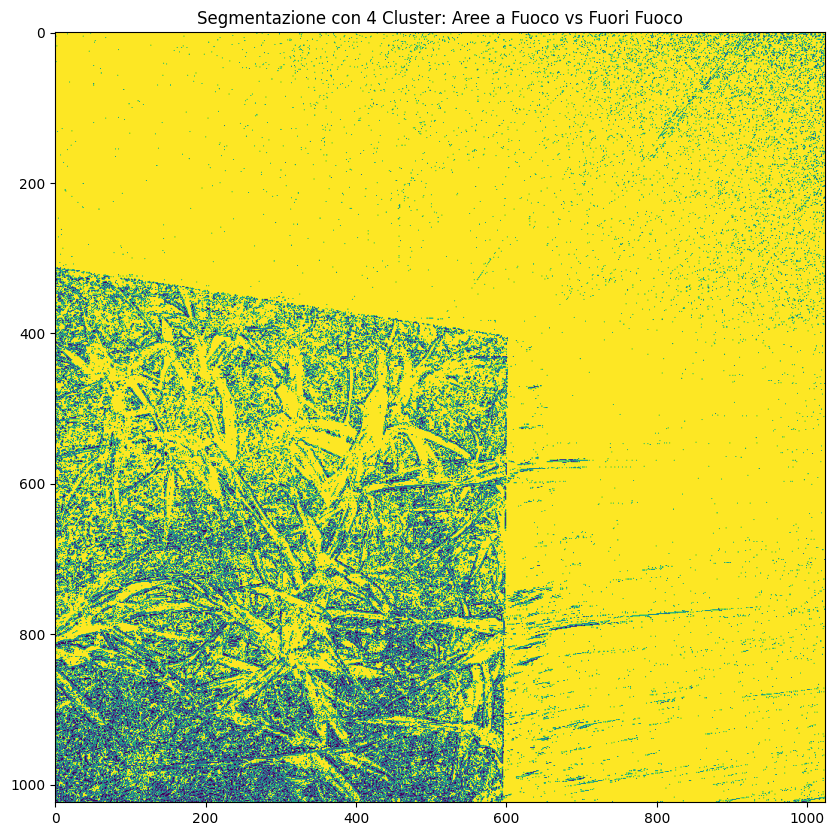

In [ ]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Carica lo stack .tif
image_stack_path = "stacks/stack1.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Crea una rappresentazione in cui ogni pixel è un vettore di 300 elementi
# La forma risultante sarà (h, w, num_layers)
pixel_vectors = np.transpose(stack, (1, 2, 0))

# Stampa la forma per verificare
print("Dimensioni della rappresentazione vettoriale:", pixel_vectors.shape)  # Dovrebbe essere (h, w, 300)

# Appiattisci la rappresentazione dei vettori pixel per adattarla a K-means
# La forma risultante sarà (h*w, num_layers)
pixel_vectors_flat = pixel_vectors.reshape(-1, num_layers)

# Applica K-means con 4 cluster (ad esempio: completamente fuori fuoco, parzialmente fuori fuoco, a fuoco, altamente a fuoco)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pixel_vectors_flat)

# Ottieni le etichette dei cluster e riorganizzale nella forma dell'immagine originale (h, w)
labels = kmeans.labels_.reshape(h, w)

# Visualizza la segmentazione con più cluster
plt.figure(figsize=(10, 10))
plt.imshow(labels)  # Usa una mappa di colori per distinguere i cluster
plt.title("Segmentazione con 4 Cluster: Aree a Fuoco vs Fuori Fuoco")
plt.show()



Dimensioni della rappresentazione vettoriale: (1024, 1024, 300)


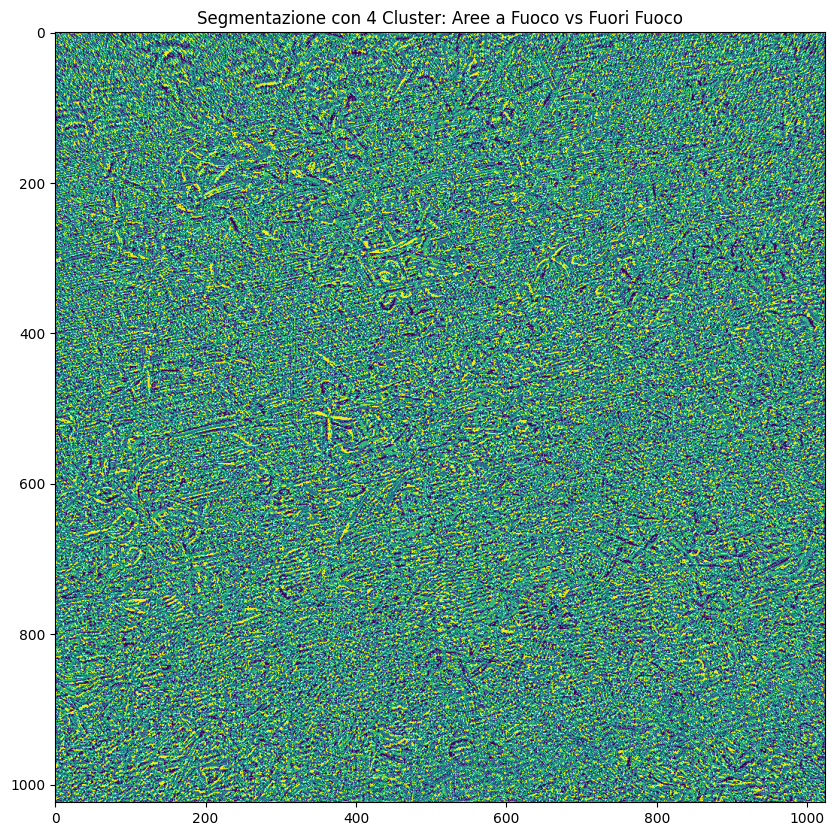

In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Carica lo stack .tif
image_stack_path = "stacks/stack2.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Crea una rappresentazione in cui ogni pixel è un vettore di 300 elementi
# La forma risultante sarà (h, w, num_layers)
pixel_vectors = np.transpose(stack, (1, 2, 0))

# Stampa la forma per verificare
print("Dimensioni della rappresentazione vettoriale:", pixel_vectors.shape)  # Dovrebbe essere (h, w, 300)

# Appiattisci la rappresentazione dei vettori pixel per adattarla a K-means
# La forma risultante sarà (h*w, num_layers)
pixel_vectors_flat = pixel_vectors.reshape(-1, num_layers)

# Applica K-means con 4 cluster (ad esempio: completamente fuori fuoco, parzialmente fuori fuoco, a fuoco, altamente a fuoco)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pixel_vectors_flat)

# Ottieni le etichette dei cluster e riorganizzale nella forma dell'immagine originale (h, w)
labels = kmeans.labels_.reshape(h, w)

# Visualizza la segmentazione con più cluster
plt.figure(figsize=(10, 10))
plt.imshow(labels)  # Usa una mappa di colori per distinguere i cluster
plt.title("Segmentazione con 4 Cluster: Aree a Fuoco vs Fuori Fuoco")
plt.show()



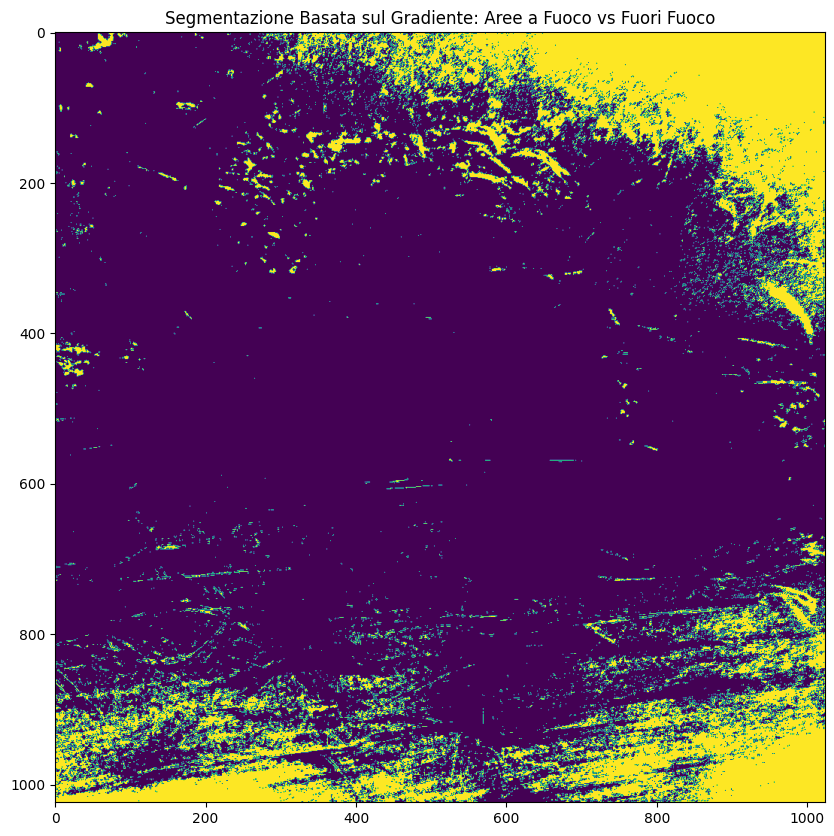

In [ ]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import sobel

# Carica lo stack .tif
image_stack_path = "stacks/stack1.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Calcola il gradiente per ciascun layer dello stack
gradient_stack = np.zeros_like(stack)
for i in range(num_layers):
    dx = sobel(stack[i], axis=1)  # Gradiente lungo l'asse x
    dy = sobel(stack[i], axis=0)  # Gradiente lungo l'asse y
    gradient_stack[i] = np.hypot(dx, dy)  # Magnitudine del gradiente

# Calcola la varianza del gradiente lungo tutti i layer per ogni pixel
gradient_variance = np.var(gradient_stack, axis=0)

# Appiattisci la varianza per adattarla a K-means
gradient_variance_flat = gradient_variance.reshape(-1, 1)

# Applica K-means con 2 cluster (fuoco vs fuori fuoco)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(gradient_variance_flat)

# Ottieni le etichette dei cluster e riorganizzale nella forma dell'immagine originale (h, w)
labels = kmeans.labels_.reshape(h, w)

# Visualizza la segmentazione basata sul gradiente
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='viridis')  # Usa una mappa di colori per distinguere i cluster
plt.title("Segmentazione Basata sul Gradiente: Aree a Fuoco vs Fuori Fuoco")
plt.show()


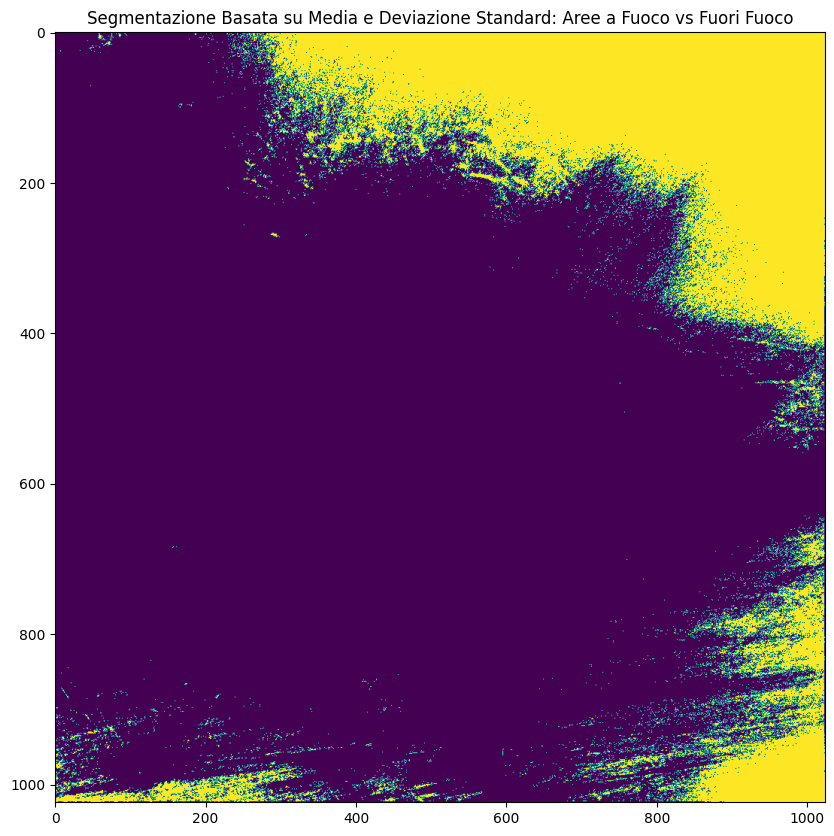

In [ ]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Carica lo stack .tif
image_stack_path = "stacks/stack1.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Calcola la media lungo l'asse dei layer per ogni pixel
mean_image = np.mean(stack, axis=0)

# Calcola la deviazione standard lungo l'asse dei layer per ogni pixel
std_image = np.std(stack, axis=0)

# Crea una rappresentazione concatenata della media e deviazione standard (h, w, 2)
features_image = np.stack([mean_image, std_image], axis=-1)

# Appiattisci la rappresentazione per adattarla a K-means
features_flat = features_image.reshape(-1, 2)

# Applica K-means con 2 cluster (fuoco vs fuori fuoco)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_flat)

# Ottieni le etichette dei cluster e riorganizzale nella forma dell'immagine originale (h, w)
labels = kmeans.labels_.reshape(h, w)

# Visualizza la segmentazione basata su media e deviazione standard
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='viridis')  # Usa una mappa di colori per distinguere i cluster
plt.title("Segmentazione Basata su Media e Deviazione Standard: Aree a Fuoco vs Fuori Fuoco")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Verifica se il dispositivo MPS è disponibile
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device utilizzato: {device}")

# Carica lo stack .tif
image_stack_path = "stacks/stack1.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Appiattisci la rappresentazione dei vettori pixel
pixel_vectors_flat = stack.reshape(-1, num_layers)

# Calcola le caratteristiche aggiuntive per ogni pixel
means = np.mean(pixel_vectors_flat, axis=1)
variances = np.var(pixel_vectors_flat, axis=1)
skewnesses = skew(pixel_vectors_flat, axis=1)
kurtoses = kurtosis(pixel_vectors_flat, axis=1)

# Concatena le caratteristiche al vettore pixel originale
features = np.column_stack((pixel_vectors_flat, means, variances, skewnesses, kurtoses))

# Definisci un dataset personalizzato per contenere i vettori pixel con caratteristiche aggiuntive
class PixelVectorDataset(Dataset):
    def __init__(self, pixel_vectors):
        self.pixel_vectors = pixel_vectors

    def __len__(self):
        return len(self.pixel_vectors)

    def __getitem__(self, idx):
        return torch.tensor(self.pixel_vectors[idx], dtype=torch.float)

# Crea un dataset e un dataloader
batch_size = 256
dataset = PixelVectorDataset(features)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Definisci il VAE
class VAE(nn.Module):
    def __init__(self, input_dim=304, latent_dim=50):  # Modificato input_dim per includere le nuove caratteristiche
        super(VAE, self).__init__()
        # Encoder: Aggiungi più strati per una maggiore profondità
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Output: mu e log_var
        )
        # Decoder: Aggiungi più strati per una maggiore profondità
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Sigmoid per valori tra 0 e 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        # Decoder
        return self.decoder(z), mu, log_var

# Funzione di perdita per il VAE
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kld_loss

# Inizializza il modello, la loss e l'optimizer
latent_dim = 50  # Dimensione del vettore latente
vae = VAE(input_dim=features.shape[1], latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.005)  # Learning rate iniziale elevato

# Definisci uno scheduler di learning rate basato su ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Addestramento del VAE
epochs = 20
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for data in dataloader:
        data = data.to(device)  # Sposta i dati sul dispositivo MPS
        # Passa i dati attraverso il VAE
        recon_data, mu, log_var = vae(data)
        loss = vae_loss(recon_data, data, mu, log_var)
        # Ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calcola la perdita media per questa epoca
    avg_loss = total_loss / len(dataset)

    # Stampa la perdita e il learning rate corrente
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Learning Rate: {current_lr}")

    # Aggiorna il learning rate secondo lo scheduler
    scheduler.step(avg_loss)

# Dopo l'addestramento, calcola l'errore di ricostruzione per ogni pixel
vae.eval()
errors = []
with torch.no_grad():
    for data in dataloader:
        data = data.to(device)  # Sposta i dati sul dispositivo MPS
        recon_data, _, _ = vae(data)
        errors.append((recon_data - data).pow(2).sum(dim=1).cpu())  # Sposta i dati su CPU per l'elaborazione

# Concatenare tutte le ricostruzioni e gli errori
errors = torch.cat(errors).numpy()

# Riorganizza l'errore di ricostruzione nella forma dell'immagine originale
errors_image = errors.reshape(h, w)

# Visualizza la mappa dell'errore di ricostruzione
plt.figure(figsize=(10, 10))
plt.imshow(errors_image, cmap='hot')
plt.title("Errore di Ricostruzione: Aree a Fuoco vs Fuori Fuoco")
plt.colorbar()
plt.show()


Device utilizzato: mps
Epoch [1/20], Loss: 123842.0536, Learning Rate: 0.005
Epoch [2/20], Loss: 123842.2104, Learning Rate: 0.005
Epoch [3/20], Loss: 123842.2104, Learning Rate: 0.005
Epoch [4/20], Loss: 123842.2104, Learning Rate: 0.005
Epoch [5/20], Loss: 123842.2103, Learning Rate: 0.0025
Epoch [6/20], Loss: 123842.2103, Learning Rate: 0.0025


KeyboardInterrupt: 

Device utilizzato: mps
Epoch [1/20], Loss: 228708034.5600, Learning Rate: 0.005
Epoch [2/20], Loss: 221977862.8267, Learning Rate: 0.005
Epoch [3/20], Loss: 221966230.1867, Learning Rate: 0.005
Epoch [4/20], Loss: 221924515.8400, Learning Rate: 0.005
Epoch [5/20], Loss: 221921604.2667, Learning Rate: 0.005
Epoch [6/20], Loss: 221918109.0133, Learning Rate: 0.005
Epoch [7/20], Loss: 221918720.0000, Learning Rate: 0.005
Epoch [8/20], Loss: 221919450.4533, Learning Rate: 0.0025
Epoch [9/20], Loss: 221913371.3067, Learning Rate: 0.0025
Epoch [10/20], Loss: 221909896.5333, Learning Rate: 0.0025
Epoch [11/20], Loss: 221907025.9200, Learning Rate: 0.00125
Epoch [12/20], Loss: 221906285.2267, Learning Rate: 0.00125
Epoch [13/20], Loss: 221904834.5600, Learning Rate: 0.00125
Epoch [14/20], Loss: 221903448.7467, Learning Rate: 0.000625
Epoch [15/20], Loss: 221902721.7067, Learning Rate: 0.000625
Epoch [16/20], Loss: 221901946.8800, Learning Rate: 0.000625
Epoch [17/20], Loss: 221901117.4400, Lea

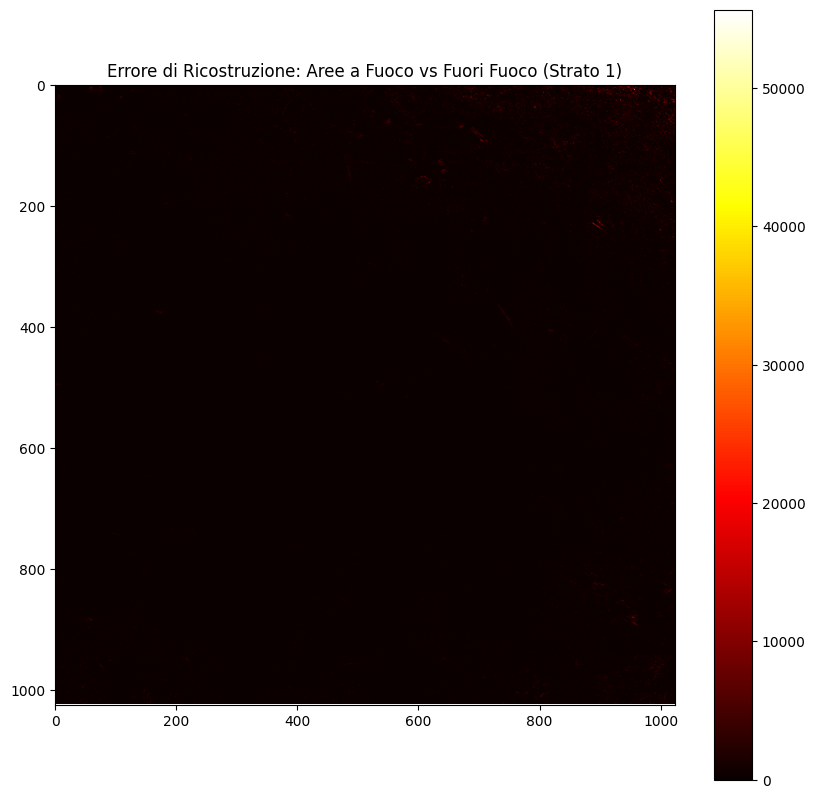

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# Verifica se il dispositivo MPS è disponibile
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device utilizzato: {device}")

# Carica lo stack .tif
image_stack_path = "stacks/stack1.tif"
stack = tifffile.imread(image_stack_path)  # Carica tutte le immagini dello stack

# Assumiamo che stack abbia dimensioni (300, h, w)
num_layers, h, w = stack.shape

# Crea un dataset per contenere le immagini
class ImageDataset(Dataset):
    def __init__(self, image_stack):
        self.image_stack = image_stack

    def __len__(self):
        return self.image_stack.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.image_stack[idx], dtype=torch.float).unsqueeze(0)  # Aggiungi il canale

# Crea un dataset e un dataloader
dataset = ImageDataset(stack)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)  # Ridotto batch_size per problemi di memoria

# Definisci la VAE-CNN
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE_CNN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (1, H, W) -> (16, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (16, H/2, W/2) -> (32, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32, H/4, W/4) -> (64, H/8, W/8)
            nn.ReLU(),
            nn.Flatten(),  # Flatten per la codifica latente
            nn.Linear((h // 8) * (w // 8) * 64, latent_dim * 2)  # Mu e LogVar
        )
        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, (h // 8) * (w // 8) * 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, H/8, W/8) -> (32, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32, H/4, W/4) -> (16, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16, H/2, W/2) -> (1, H, W)
            nn.Sigmoid()  # Sigmoid per valori tra 0 e 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        # Decoder
        x = self.decoder_fc(z)
        x = x.view(-1, 64, h // 8, w // 8)  # Reshape per il decoder convoluzionale
        return self.decoder(x), mu, log_var

# Funzione di perdita per il VAE
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kld_loss

# Inizializza il modello, la loss e l'optimizer
latent_dim = 20
vae_cnn = VAE_CNN(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae_cnn.parameters(), lr=0.005)

# Definisci uno scheduler di learning rate basato su ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Addestramento del VAE-CNN
epochs = 20
for epoch in range(epochs):
    vae_cnn.train()
    total_loss = 0
    for data in dataloader:
        data = data.to(device)  # Sposta i dati sul dispositivo MPS
        # Passa i dati attraverso il VAE
        recon_data, mu, log_var = vae_cnn(data)
        loss = vae_loss(recon_data, data, mu, log_var)
        # Ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calcola la perdita media per questa epoca
    avg_loss = total_loss / len(dataset)

    # Stampa la perdita e il learning rate corrente
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Learning Rate: {current_lr}")

    # Aggiorna il learning rate secondo lo scheduler
    scheduler.step(avg_loss)

# Dopo l'addestramento, calcola l'errore di ricostruzione per ogni pixel
vae_cnn.eval()
errors = []
with torch.no_grad():
    for data in dataloader:
        data = data.to(device)  # Sposta i dati sul dispositivo MPS
        recon_data, _, _ = vae_cnn(data)
        error = (recon_data - data).pow(2).mean(dim=1).cpu()  # Calcola l'errore medio su ciascun canale
        errors.append(error)

# Concatenare tutte le ricostruzioni degli errori
errors = torch.cat(errors, dim=0).numpy()

# Assicurati che la dimensione dell'array degli errori sia compatibile
if errors.shape[0] != num_layers:
    raise ValueError(f"La dimensione degli errori ({errors.shape[0]}) non corrisponde al numero di strati ({num_layers})")

# Riorganizza l'errore di ricostruzione nella forma dello stack originale (num_layers, h, w)
errors_image = errors.reshape(num_layers, h, w)

# Visualizza la mappa dell'errore di ricostruzione per uno degli strati
plt.figure(figsize=(10, 10))
plt.imshow(errors_image[0], cmap='hot')  # Visualizza il primo strato
plt.title("Errore di Ricostruzione: Aree a Fuoco vs Fuori Fuoco (Strato 1)")
plt.colorbar()
plt.show()



Epoch [1/20] Loss: 0.3210
Epoch [2/20] Loss: 0.0398
Epoch [3/20] Loss: 0.0397
Epoch [4/20] Loss: 0.0397
Epoch [5/20] Loss: 0.0397
Epoch [6/20] Loss: 0.0397
Epoch [7/20] Loss: 0.0398
Epoch [8/20] Loss: 0.0398
Epoch [9/20] Loss: 0.0398
Epoch [10/20] Loss: 0.0398
Epoch [11/20] Loss: 0.0398
Epoch [12/20] Loss: 0.0398
Epoch [13/20] Loss: 0.0398
Epoch [14/20] Loss: 0.0398
Epoch [15/20] Loss: 0.0398
Epoch [16/20] Loss: 0.0398
Epoch [17/20] Loss: 0.0398
Epoch [18/20] Loss: 0.0398
Epoch [19/20] Loss: 0.0398
Epoch [20/20] Loss: 0.0398


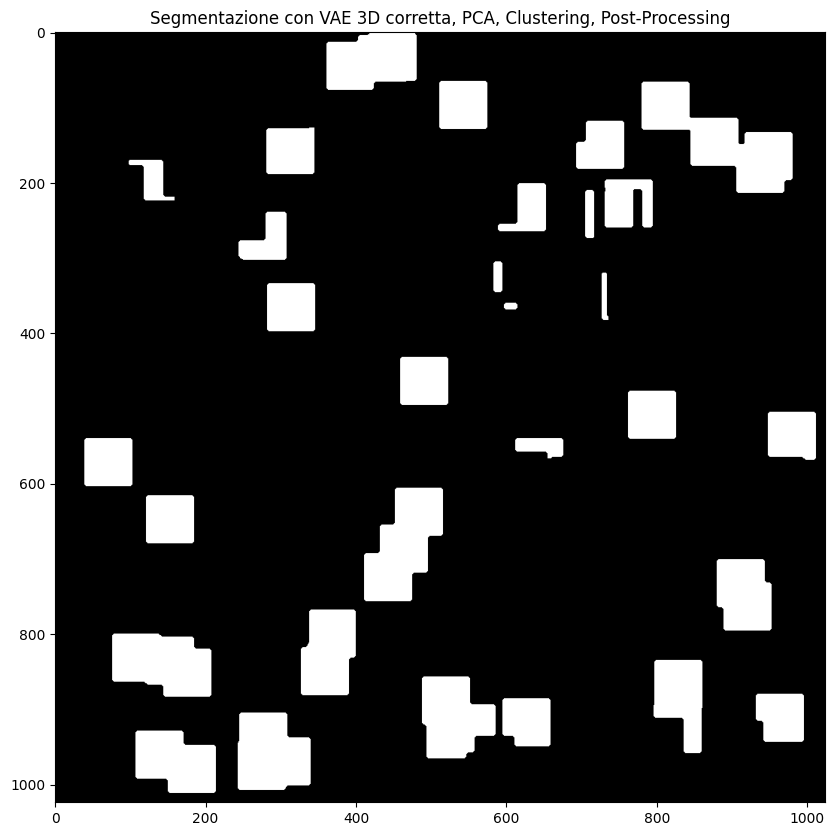

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from torch.optim.lr_scheduler import StepLR

# Dataset come prima, ma con depth=16 per semplificare.
class Stack3DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, depth=16, num_patches=1000):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        self.patch_size = patch_size
        self.depth = depth
        self.num_patches = num_patches
        
        self.coords = []
        for _ in range(num_patches):
            l = np.random.randint(0, self.num_layers - depth)
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((l, y, x))

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        l, y, x = self.coords[idx]
        vol = self.stack[l:l+self.depth, y:y+self.patch_size, x:x+self.patch_size].astype(np.float32)
        max_val = vol.max() if vol.max() > 0 else 1.0
        vol /= max_val
        # shape: (depth, H, W) -> (1, depth, H, W)
        vol = torch.from_numpy(vol).unsqueeze(0)
        return vol

class VAE3D(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE3D, self).__init__()
        # Encoder
        # Input: (1,16,64,64)
        # 4 downsampling steps, each stride=2
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),  # (32,8,32,32)
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1), # (64,4,16,16)
            nn.ReLU(),
            nn.Conv3d(64,128, kernel_size=3, stride=2, padding=1), # (128,2,8,8)
            nn.ReLU(),
            nn.Conv3d(128,256,kernel_size=3, stride=2, padding=1), # (256,1,4,4)
            nn.ReLU(),
        )

        self.flatten_dim = 256*1*4*4
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_var = nn.Linear(self.flatten_dim, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        
        # Usare kernel=2, stride=2, padding=0 per raddoppiare esattamente le dimensioni
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256,1,4,4)),
            nn.ConvTranspose3d(256,128,kernel_size=2,stride=2,padding=0), # D:1->2,H/W:4->8
            nn.ReLU(),
            nn.ConvTranspose3d(128,64, kernel_size=2,stride=2,padding=0), # D:2->4,H/W:8->16
            nn.ReLU(),
            nn.ConvTranspose3d(64,32,  kernel_size=2,stride=2,padding=0), # D:4->8,H/W:16->32
            nn.ReLU(),
            nn.ConvTranspose3d(32,1,   kernel_size=2,stride=2,padding=0), # D:8->16,H/W:32->64
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        x_recon = self.decoder(h)
        return x_recon
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.MSELoss()(recon_x, x)
    kld = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + 0.0001*kld

stack_path = "stacks/stack1.tif"
dataset = Stack3DDataset(stack_path, patch_size=64, depth=16, num_patches=200)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cpu")
model = VAE3D(latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 20
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon, mu, log_var = model(batch)
        loss = vae_loss(recon, batch, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(dataloader):.4f}")

# Estrazione feature e clustering come prima
dataset_for_cluster = Stack3DDataset(stack_path, patch_size=64, depth=16, num_patches=100)
dataloader_for_cluster = DataLoader(dataset_for_cluster, batch_size=2, shuffle=False)

model.eval()
features = []
coords = dataset_for_cluster.coords
with torch.no_grad():
    for batch in dataloader_for_cluster:
        batch = batch.to(device)
        mu, log_var = model.encode(batch)
        z = mu.cpu().numpy()
        features.append(z)
features = np.concatenate(features, axis=0)

pca = PCA(n_components=20, random_state=42)
pca_features = pca.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(pca_features)

H = dataset_for_cluster.H
W = dataset_for_cluster.W
patch_size = dataset_for_cluster.patch_size
prob_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.float32)

for i, (l,y,x) in enumerate(coords):
    label = labels[i]
    val = float(label)
    prob_map[y:y+patch_size, x:x+patch_size] += val
    count_map[y:y+patch_size, x:x+patch_size] += 1.0

mask = np.zeros((H,W), dtype=np.float32)
valid = (count_map > 0)
mask[valid] = prob_map[valid]/count_map[valid]

binary_map = (mask > 0.5).astype(np.uint8)

# Post-processing
binary_map = median_filter(binary_map, size=5) # Mediano per ridurre rumore
binary_map = opening(binary_map, square(5))
binary_map = closing(binary_map, square(5))

plt.figure(figsize=(10,10))
plt.imshow(binary_map, cmap='gray')
plt.title("Segmentazione con VAE 3D corretta, PCA, Clustering, Post-Processing")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap  # Assicurati di aver fatto: pip install umap-learn
import matplotlib.pyplot as plt
from torchvision import transforms

class Patch2DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=5000, use_layer='mean'):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        
        if use_layer == 'mean':
            self.img = self.stack.mean(axis=0).astype(np.float32)
        elif use_layer == 'middle':
            l = self.num_layers // 2
            self.img = self.stack[l].astype(np.float32)
        else:
            l = int(use_layer)
            self.img = self.stack[l].astype(np.float32)
        
        max_val = self.img.max() if self.img.max()>0 else 1.0
        self.img /= max_val
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x)

class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

stack_path = "stacks/stack1.tif"
patch_size = 2
num_patches = 100000

dataset = Patch2DDataset(stack_path, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("cpu") 
encoder = SmallEncoder(out_dim=128)
model = SimCLR(encoder).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 3500
loss_history = []  # Lista per salvare la loss di ogni epoca

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for (view1, view2, _) in dataloader:
        view1 = view1.to(device)
        view2 = view2.to(device)
        optimizer.zero_grad()
        loss = model(view1, view2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss/len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")

# Plot della loss vs epoche
plt.figure()
plt.plot(loss_history)
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_plot.png", dpi=300)
plt.close()  # chiudiamo il plot per non mostrarlo a schermo

model.eval()
dataset_for_cluster = Patch2DDataset(stack_path, patch_size=64, num_patches=2000, use_layer='mean')
dataloader_for_cluster = DataLoader(dataset_for_cluster, batch_size=64, shuffle=False)

features = []
coords = dataset_for_cluster.coords
with torch.no_grad():
    for (view1, view2, c) in dataloader_for_cluster:
        view1 = view1.to(device)
        z = model.encoder(view1)
        z = z.cpu().numpy()
        features.append(z)
features = np.concatenate(features, axis=0)

reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = reducer.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(umap_features)

H, W = dataset_for_cluster.H, dataset_for_cluster.W
patch_size = dataset_for_cluster.patch_size
prob_map = np.zeros((H,W), dtype=np.float32)
count_map = np.zeros((H,W), dtype=np.float32)

for i, (y,x) in enumerate(coords):
    val = float(labels[i])
    prob_map[y:y+patch_size, x:x+patch_size] += val
    count_map[y:y+patch_size, x:x+patch_size] += 1.0

mask = np.zeros((H,W), dtype=np.float32)
valid = (count_map>0)
mask[valid] = prob_map[valid]/count_map[valid]
binary_map = (mask>0.5).astype(np.uint8)

binary_map = median_filter(binary_map, size=5)
binary_map = opening(binary_map, square(5))
binary_map = closing(binary_map, square(5))

plt.figure(figsize=(10,10))
plt.imshow(binary_map, cmap='gray')
plt.title("Segmentazione con SimCLR (Self-Supervised), UMAP, K-Means, Post-Processing")
plt.show()


Epoch [1/3500] Loss: 2.2130
Epoch [2/3500] Loss: 1.8987
Epoch [3/3500] Loss: 1.8162
Epoch [4/3500] Loss: 1.7566
Epoch [5/3500] Loss: 1.7110
Epoch [6/3500] Loss: 1.7026
Epoch [7/3500] Loss: 1.6773
Epoch [8/3500] Loss: 1.6599
Epoch [9/3500] Loss: 1.6364
Epoch [10/3500] Loss: 1.5948
Epoch [11/3500] Loss: 1.5686
Epoch [12/3500] Loss: 1.5339
Epoch [13/3500] Loss: 1.5153
Epoch [14/3500] Loss: 1.4978
Epoch [15/3500] Loss: 1.4927
Epoch [16/3500] Loss: 1.4766
Epoch [17/3500] Loss: 1.4739
Epoch [18/3500] Loss: 1.4573
Epoch [19/3500] Loss: 1.4385
Epoch [20/3500] Loss: 1.4384
Epoch [21/3500] Loss: 1.4283
Epoch [22/3500] Loss: 1.4303
Epoch [23/3500] Loss: 1.4223
Epoch [24/3500] Loss: 1.4146
Epoch [25/3500] Loss: 1.4151
Epoch [26/3500] Loss: 1.4083
Epoch [27/3500] Loss: 1.4024
Epoch [28/3500] Loss: 1.4054
Epoch [29/3500] Loss: 1.4011
Epoch [30/3500] Loss: 1.3975
Epoch [31/3500] Loss: 1.3895
Epoch [32/3500] Loss: 1.3902
Epoch [33/3500] Loss: 1.3899
Epoch [34/3500] Loss: 1.3836
Epoch [35/3500] Loss: 1

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap  # Assicurati di aver fatto: pip install umap-learn
import matplotlib.pyplot as plt
from torchvision import transforms

class Patch2DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=5000, use_layer='mean'):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        
        if use_layer == 'mean':
            self.img = self.stack.mean(axis=0).astype(np.float32)
        elif use_layer == 'middle':
            l = self.num_layers // 2
            self.img = self.stack[l].astype(np.float32)
        else:
            l = int(use_layer)
            self.img = self.stack[l].astype(np.float32)
        
        max_val = self.img.max() if self.img.max()>0 else 1.0
        self.img /= max_val
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x)

class SmallEncoder(nn.Module):
    def __init__(self, out_dim=128):
        super(SmallEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,2,1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(64, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

stack_path = "stacks/stack1.tif"
patch_size = 32
num_patches = 50000

dataset = Patch2DDataset(stack_path, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Usa MPS se disponibile, altrimenti CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = SmallEncoder(out_dim=128)
model = SimCLR(encoder).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 1000
loss_history = []

# Parametri Early Stopping
best_loss = float('inf')
patience = 101  # ad esempio, fermati se non migliora per 200 epoche
no_improvement_count = 0

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for (view1, view2, _) in dataloader:
        view1 = view1.to(device)
        view2 = view2.to(device)
        optimizer.zero_grad()
        loss = model(view1, view2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss/len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")
    
    # Controllo Early Stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement_count = 0
        # Salva il modello migliore
        torch.save(model.state_dict(), f"best_model_SimCLR_{patch_size}.pth")
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

# Plot della loss vs epoche
plt.figure()
plt.plot(loss_history)
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_plot.png", dpi=300)
plt.close()


Using device: mps
Epoch [1/3500] Loss: 3.3151
Epoch [2/3500] Loss: 1.7458
Epoch [3/3500] Loss: 1.5831
Epoch [4/3500] Loss: 1.4732
Epoch [5/3500] Loss: 1.3832
Epoch [6/3500] Loss: 1.2103
Epoch [7/3500] Loss: 1.0469
Epoch [8/3500] Loss: 0.9076
Epoch [9/3500] Loss: 0.8192
Epoch [10/3500] Loss: 0.7495
Epoch [11/3500] Loss: 0.6874
Epoch [12/3500] Loss: 0.6502
Epoch [13/3500] Loss: 0.6219
Epoch [14/3500] Loss: 0.6008
Epoch [15/3500] Loss: 0.5715
Epoch [16/3500] Loss: 0.5537
Epoch [17/3500] Loss: 0.5236
Epoch [18/3500] Loss: 0.5094
Epoch [19/3500] Loss: 0.4847
Epoch [20/3500] Loss: 0.4838
Epoch [21/3500] Loss: 0.4620
Epoch [22/3500] Loss: 0.4557
Epoch [23/3500] Loss: 0.4425
Epoch [24/3500] Loss: 0.4322
Epoch [25/3500] Loss: 0.4194
Epoch [26/3500] Loss: 0.4202
Epoch [27/3500] Loss: 0.3993
Epoch [28/3500] Loss: 0.3965
Epoch [29/3500] Loss: 0.3923
Epoch [30/3500] Loss: 0.3842
Epoch [31/3500] Loss: 0.3668
Epoch [32/3500] Loss: 0.3748
Epoch [33/3500] Loss: 0.3667
Epoch [34/3500] Loss: 0.3627
Epoch

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tifffile
import numpy as np
import random
from skimage.morphology import closing, opening, square
from scipy.ndimage import median_filter
from sklearn.cluster import KMeans
import umap.umap_ as umap  # Assicurati di aver fatto: pip install umap-learn
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F

class Patch2DDataset(Dataset):
    def __init__(self, stack_path, patch_size=64, num_patches=5000, use_layer='mean'):
        self.stack = tifffile.imread(stack_path) # (num_layers,H,W)
        self.num_layers, self.H, self.W = self.stack.shape
        
        if use_layer == 'mean':
            self.img = self.stack.mean(axis=0).astype(np.float32)
        elif use_layer == 'middle':
            l = self.num_layers // 2
            self.img = self.stack[l].astype(np.float32)
        else:
            l = int(use_layer)
            self.img = self.stack[l].astype(np.float32)
        
        max_val = self.img.max() if self.img.max()>0 else 1.0
        self.img /= max_val
        
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.coords = []
        for _ in range(num_patches):
            y = np.random.randint(0, self.H - patch_size)
            x = np.random.randint(0, self.W - patch_size)
            self.coords.append((y,x))
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y,x = self.coords[idx]
        patch = self.img[y:y+self.patch_size, x:x+self.patch_size]
        patch_pil = transforms.ToPILImage()(patch)
        view1 = self.transform(patch_pil)
        view2 = self.transform(patch_pil)
        return view1, view2, (y,x)

class DeeperEncoder(nn.Module):
    def __init__(self, out_dim=128, dropout_p=0.1):
        super(DeeperEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),   # 1->16, 64x64->32x32
            nn.LayerNorm([16,32,32]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(16,32,3,2,1),  # 16->32, 32x32->16x16
            nn.LayerNorm([32,16,16]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(32,64,3,2,1),  # 32->64, 16x16->8x8
            nn.LayerNorm([64,8,8]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(64,128,3,2,1), # 64->128, 8x8->4x4
            nn.LayerNorm([128,4,4]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.Conv2d(128,256,3,2,1),# 128->256, 4x4->2x2
            nn.LayerNorm([256,2,2]),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),

            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Linear(256, out_dim)

    def forward(self,x):
        h = self.net(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

class SimCLR(nn.Module):
    def __init__(self, encoder, temperature=0.07):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.temperature = temperature

    def forward(self, x1, x2):
        z1 = self.encoder(x1)
        z2 = self.encoder(x2)
        
        z1 = z1 / z1.norm(dim=1, keepdim=True)
        z2 = z2 / z2.norm(dim=1, keepdim=True)
        
        batch_size = z1.size(0)
        sim = torch.matmul(z1, z2.T)
        
        labels = torch.arange(batch_size).to(z1.device)
        
        sim_div = sim / self.temperature
        log_prob = nn.LogSoftmax(dim=1)(sim_div)
        loss = -log_prob[range(batch_size), labels].mean()
        return loss

stack_path = "stacks/stack1.tif"
patch_size = 64
num_patches = 50000

dataset = Patch2DDataset(stack_path, patch_size=patch_size, num_patches=num_patches, use_layer='mean')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Usa MPS se disponibile, altrimenti CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

encoder = DeeperEncoder(out_dim=128, dropout_p=0.1)  # Usa l'encoder profondo
model = SimCLR(encoder).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 1000
loss_history = []

# Parametri Early Stopping
best_loss = float('inf')
patience = 101
no_improvement_count = 0

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for (view1, view2, _) in dataloader:
        view1 = view1.to(device)
        view2 = view2.to(device)
        optimizer.zero_grad()
        loss = model(view1, view2)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    epoch_loss = running_loss/len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")
    
    # Controllo Early Stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        no_improvement_count = 0
        torch.save(model.state_dict(), f"best_model_SimCLR_deep5_{patch_size}.pth")
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered!")
            break

# Plot della loss vs epoche
plt.figure()
plt.plot(loss_history)
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("loss_plot.png", dpi=300)
plt.close()

Using device: mps
Epoch [1/1000] Loss: 4.1576
Epoch [2/1000] Loss: 4.1555
Epoch [3/1000] Loss: 2.8202
Epoch [4/1000] Loss: 0.5307
Epoch [5/1000] Loss: 0.3464
Epoch [6/1000] Loss: 0.2693
Epoch [7/1000] Loss: 0.2233
Epoch [8/1000] Loss: 0.1881
Epoch [9/1000] Loss: 0.1670
Epoch [10/1000] Loss: 0.1492
Epoch [11/1000] Loss: 0.1349
Epoch [12/1000] Loss: 0.1205
Epoch [13/1000] Loss: 0.1096
Epoch [14/1000] Loss: 0.1018
Epoch [15/1000] Loss: 0.0970
Epoch [16/1000] Loss: 0.0893
Epoch [17/1000] Loss: 0.0856
Epoch [18/1000] Loss: 0.0824
Epoch [19/1000] Loss: 0.0768
Epoch [20/1000] Loss: 0.0748
Epoch [21/1000] Loss: 0.0725
Epoch [22/1000] Loss: 0.0676
Epoch [23/1000] Loss: 0.0674
Epoch [24/1000] Loss: 0.0641
Epoch [25/1000] Loss: 0.0643
Epoch [26/1000] Loss: 0.0613
Epoch [27/1000] Loss: 0.0610
Epoch [28/1000] Loss: 0.0588
Epoch [29/1000] Loss: 0.0572
Epoch [30/1000] Loss: 0.0563
Epoch [31/1000] Loss: 0.0550
Epoch [32/1000] Loss: 0.0533
Epoch [33/1000] Loss: 0.0534
Epoch [34/1000] Loss: 0.0527
Epoch